In [2]:
import numpy as np
import os
import cv2
import numpy as np
from skimage import exposure

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))


def trainPerceptron(train_set, train_labels,learning_rate, max_iter):
    input_size = train_set.shape[1]
    hidden_size = 16  # Number of neurons in the hidden layer
    
    # Initialize weights and biases for the hidden layer
    W1 = np.random.randn(input_size, hidden_size)
    b1 = np.zeros((1, hidden_size))
    
    # Initialize weights and biases for the output layer
    W2 = np.random.randn(hidden_size)
    b2 = 0
    
    for iteration in range(max_iter):
        for i, image in enumerate(train_set):
            # Forward propagation
            hidden_output = sigmoid(np.dot(image, W1) + b1)
            output = sigmoid(np.dot(hidden_output, W2) + b2)
            
            # Backpropagation
            output_error = train_labels[i] - output
            hidden_error = output_error * sigmoid_derivative(output) * W2
            
            # Update weights and biases using gradient descent
            W2 += learning_rate * hidden_output.flatten() * output_error
            b2 += learning_rate * output_error
            W1 += learning_rate * np.outer(image, hidden_error) * sigmoid_derivative(hidden_output)
            b1 += learning_rate * hidden_error * sigmoid_derivative(hidden_output)
    
    return W1, b1, W2, b2

def classifyPerceptron(train_set, train_labels, dev_set, learning_rate, max_iter):
    W1, b1, W2, b2 = trainPerceptron(train_set, train_labels, learning_rate, max_iter)
    ret = []
    for image in dev_set:
        hidden_output = sigmoid(np.dot(image, W1) + b1)
        output = sigmoid(np.dot(hidden_output, W2) + b2)
        if output <= 0.5:
            ret.append(0)
        else:
            ret.append(1)
    return ret

def classify_eye(W1, b1, W2, b2, image):
    hidden_output = np.dot(image, W1) + b1
    print(hidden_output)
    hidden_output = sigmoid(hidden_output)
    print(hidden_output)
    output = sigmoid(np.dot(hidden_output, W2) + b2)
    if output <= 0.5:
        return 0
    else:
        return 1


In [3]:
eye_cascade_path = '/Users/henrythomas/Desktop/ECE420/Final_Project/haarcascade_eye.xml'
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

def process_image_eye(image_array, target_size=(64, 64)):
    # Convert the 1D array to 2D array (64x64 image)
    image = np.reshape(image_array, (64, 64))


    # Convert the image to uint8 for OpenCV
    image_uint8 = np.uint8(image)
    
    # Detect eyes in the image
    eyes = eye_cascade.detectMultiScale(image_uint8, scaleFactor=1.03, minNeighbors=2, minSize=(15, 15), maxSize=(40, 40))

    # If at least one eye is detected, process the first one
    if len(eyes) > 0:
        (x, y, w, h) = eyes[0]  # Get the coordinates of the first eye

        # Crop the eye
        eye = image_uint8[y:y + h, x:x + w]

        # Resize the eye to the target size
        resized_eye = cv2.resize(eye, target_size)

        # Flatten the 2D resized eye to 1D array
        return resized_eye.flatten()

    # If no eye is detected, return None
    return None

    
def normalize_image(image):
    # Reshape image to 2D array of size (64, 64)
    image_2d = np.reshape(image, (64, 64))
    
    # Equalize histogram to improve contrast
    equalized = cv2.equalizeHist(image_2d.astype(np.uint8))
    
    # Flatten image
    flattened = equalized.flatten()
    
    return flattened


def find_eye_norm(images_array):
    ret_img = []
    non_norm = []
    for i in range(np.shape(images_array)[0]):
        image = process_image_eye(images_array[i])
        if image is not None:
            non_norm.append(image)
            normalized_image = normalize_image(image)
            ret_img.append(normalized_image)
    # Convert the list of detected faces to a NumPy array
    print(np.shape(ret_img))
    ret_img = np.array(ret_img, dtype=np.int8)
    return ret_img, non_norm

def move_ave(queue, inp):
    queue.pop(0)
    queue.append(inp)
    return np.mean(queue)



In [4]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path) and filename.endswith('.png'):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Resize image to 64x64
                img = cv2.resize(img, (64, 64))
                flattened_img = img.flatten()
                images.append(flattened_img)
    return images


# Folder paths
open_folder = "eye_data/train/Open_Eyes"
closed_folder = "eye_data/train/Closed_Eyes"
test_open_folder = 'eye_data/test/Open_Eyes'
test_closed_folder = 'eye_data/test/Closed_Eyes'

# Load images from folders
open_images = load_images_from_folder(open_folder)
closed_images = load_images_from_folder(closed_folder)
test_open_images = load_images_from_folder(test_open_folder)
test_closed_images = load_images_from_folder(test_closed_folder)


# Convert images to numpy arrays
open_data = np.array(open_images)
closed_data = np.array(closed_images)
test_open_data = np.array(test_open_images)
test_closed_data = np.array(test_closed_images)

print(np.shape(open_data))


(1640, 4096)


In [10]:
eyes_open, eyes_open_reg = find_eye_norm(open_data)
eyes_closed, eyes_closed_reg = find_eye_norm(closed_data)
test_open, test_open_reg = find_eye_norm(test_open_data)
test_closed, test_closed_reg = find_eye_norm(test_closed_data)
test = np.concatenate((test_open[0:100], test_closed[0:100]))

min_ = (int)(min(eyes_open.shape[0], eyes_closed.shape[0]))

train_set = np.concatenate((eyes_open[0:min_], eyes_closed[0:min_]))
label_set = np.concatenate((np.ones(min_), np.zeros(min_)))

confirm_set = np.concatenate((eyes_open[50:60], eyes_closed[50:60]))

classify = classifyPerceptron(train_set, label_set, test,.001 , 20)


(1477, 4096)
(388, 4096)
(357, 4096)
(97, 4096)


/var/folders/hy/kjn0xlds5mn12wjshd4qn57w0000gn/T/ipykernel_23575/3350134777.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


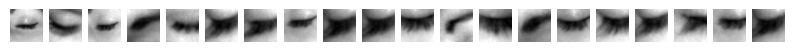

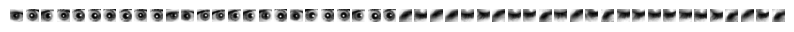

[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
import matplotlib.pyplot as plt

def show_images(images, n):
    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(np.array(images[i].reshape(64, 64), dtype=np.uint8), cmap='gray')
        plt.axis('off')
    plt.show()
    
show_images(eyes_closed_reg, 20)
# show_images(smiles, 20)
# show_images(not_smiles, 20)
show_images(test[25:75], 50)
print(classify[25:50])
print(classify[50:75])

In [14]:
print(classify[0:100])
print(np.sum(classify[0:100]))
print(np.sum(classify[100:200]))
print(64+97)


[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1]
64
3
161


In [6]:
w1,b1,w2,b2 = trainPerceptron(train_set, label_set, .001, 20)


/var/folders/hy/kjn0xlds5mn12wjshd4qn57w0000gn/T/ipykernel_82386/3350134777.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [7]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

q = []
q_len = 10
for i in range(q_len):
    q.append(0)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert frame to grayscale for face and eye detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    
    for (x, y, w, h) in faces:
        # Draw a rectangle around the detected face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Extract the region of interest (ROI) containing the face
        face_roi = gray[y:y+h, x:x+w]
        
        # Calculate the upper half of the face region
        upper_face_roi = gray[y:y+h//2, x:x+w]

        # Detect eyes within the upper half of the face region
        eyes = eye_cascade.detectMultiScale(upper_face_roi, scaleFactor=1.04, minNeighbors=3, minSize=(30, 30), maxSize=(100,100))
        
        for i, (ex, ey, ew, eh) in enumerate(eyes):
            if i >= 2:
                break
            
            # Draw a rectangle around the detected eye
            cv2.rectangle(frame, (x+ex, y+ey), (x+ex+ew, y+ey+eh), (0, 255, 0), 2)
            
            # Process the eye image and classify
            eye_roi = gray[y+ey:y+ey+eh, x+ex:x+ex+ew]
            res = cv2.resize(eye_roi, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
            image = normalize_image(res)  # Assuming you have a function to normalize the image
            eye_label = classify_eye(w1, b1, w2, b2, image)  # You need to implement classify_eye function
            
            # Display eye label
#             if eye_label == 1:
#                 cv2.putText(frame, "Eye open", (x+ex, y+ey-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
#             else:
#                 cv2.putText(frame, "Eye closed", (x+ex, y+ey-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
#     # Display the frame
    cv2.imshow('Eye Detection', frame)
    
    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close OpenCV windows
cap.release()
cv2.destroyAllWindows()


2024-05-01 12:29:36.189 python[82386:5183478] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


[[   990.08360381 -16639.12740633  15946.31185969 -16030.13062275
   -9127.0168986   -3516.54635027   1402.69611264  12388.18447565
   11256.72190359 -10405.18299544  10295.8540095  -12170.02024355
    4424.2346795    6434.85470152   5555.45769941    132.54818693]]
[[1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.]]
[[  8357.91351341  -4908.66972987  20445.82387144 -15746.24662545
  -17409.60058269  10554.94898033  12857.65287033   1130.70250921
   14876.23424602 -15116.1768856    2235.88051366   2502.10161628
    5308.9581158    5994.5857267    -490.1017879   -9622.61081415]]
[[1.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 0.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.41741801e-213 0.00000000e+000]]


/var/folders/hy/kjn0xlds5mn12wjshd4qn57w0000gn/T/ipykernel_82386/3350134777.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


[[  5297.02499341  -6736.95010741  16433.30126061 -16887.66407928
  -15130.97367667    855.05630238  17746.47660938    246.02747943
   13828.79661827 -13114.33058496   -527.0441304    3298.37883133
    3692.08749685   7393.66539601  -5046.10965713  -7622.26859111]]
[[1.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 0.00000000e+000 1.28127528e-229 1.00000000e+000
  1.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000]]
[[  4880.43656179 -17345.36828549  14597.41489489 -18063.19962014
   -6466.56027082  -3915.2503016    4406.32499038   5444.24881023
    7165.94263724 -12580.67803922  14469.22744407   4344.80426391
     521.44052221   8985.60491335   7406.93354849  -1001.06775523]]
[[1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.]]
[[   691.81251481  -4673.57344967  16237.35348299 -18001.13679396
  -11557.49482131   6205.69135509   9269.27205757     57.26575834
    8130.0985208  

[[ -1383.94566066 -22381.19124365  23175.71206617 -17600.1713641
  -17171.87196289 -10558.4469232     416.93020165  12095.3235636
   20157.49740506  -9241.55198344   2505.60097361 -21708.14729822
    6418.28871654  14397.04917621  -3918.60732296    724.97251424]]
[[0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1.]]
[[  2653.36059594  -7191.48664377  24433.00592816 -22327.17531606
  -16037.35714601   6684.93595272  15219.64661504   4866.51421487
   13290.45727414 -12988.29005183   2409.97953565  -1660.62969811
    9840.88115983   7061.08939396   3407.50196333 -11931.7731893 ]]
[[1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0.]]
[[  3253.26889437  -4712.39462379  21488.9541715  -19316.00055129
  -16543.47731635   6555.7244489   15037.34780995   6013.92925349
   15902.80874321 -13040.57082877   3944.70180551  -1871.7631524
    8089.65765032   7181.78325506   2043.49073979 -12109.29433876]]
[[1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0.]]
[[ -4930.54681926 -21914.10306944  21444.19745281

[[  3877.91608143  -6398.87822108  19999.28708976 -16868.32517919
  -18394.74066882   2990.61978827  11602.15644888   4359.38026522
   14415.17538432 -14133.47722608   2627.23084841  -3510.60164505
    8805.85128491   6247.44845249  -2867.58754436  -9694.85580983]]
[[1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0.]]
[[  -427.3293659  -22119.99510479  19584.22370107 -17755.34854249
  -13249.68677817  -8350.81665749   1032.13485947  11183.52865184
   19938.32710023 -13076.89836915   3932.26788601 -18980.93400355
    5654.09425897  14648.22325001 -10431.08150692  -1740.29435992]]
[[2.58949117e-186 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  1.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000]]
[[  2303.63209581  -6273.52869475  22010.95913004 -18405.04937237
  -18090.96776591   7832.04879409  14306.04095031   5204.4519191
   13357.54571068 -

[[  1301.70462132  -5565.38070766  22202.61226663 -18022.53696243
  -15896.24619165   6466.80881278  14285.41828468   3980.82068009
   13449.03609785 -14773.39572916    977.91893483    870.17903714
    3698.82733775   5459.87998581  -1366.59897761 -12973.92926978]]
[[1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0.]]
[[   583.26400995 -16988.64950717  20960.76628075 -18928.01462338
  -14538.54874331  -3021.1882975    3744.08498116  10797.75364553
   18702.47472694 -12036.66091683   9718.25071265 -13678.66262102
    6133.43765613  12261.01115638   1186.25298916    458.59761934]]
[[1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.]]
[[  3764.73318659  -4739.76904067  18515.19906361 -16775.35557351
  -15533.84252442   5202.55918553  12739.10225521     27.36191006
   13612.8614705  -13866.08485843   3789.07703421  -1322.3551207
    6730.56416239   9022.40375789  -4675.05740196  -9460.09547367]]
[[1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0.]]
[[  3174.16721918 -13767.53495729  16643.730591

[[  5551.11266181  -7968.29317069  19338.851071   -14819.74785577
  -17298.46129987   5206.61435916  10076.70637994   1218.09325546
   13748.34271288 -14843.14963468   1791.01648146  -2313.2799769
    6613.02475168   3863.21041651  -3059.1838794   -8210.2883187 ]]
[[1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0.]]
[[  2885.66246833 -16629.95586904  19565.4240147  -17636.70417993
  -16505.53921159  -3097.97840353   4558.10588958   9803.37811669
   19309.65773402 -11297.38866906  11691.56108414  -9095.64101936
    7777.13713758  13136.52637841   4345.33703302   -523.56127318]]
[[1.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 4.17088409e-228]]
[[  3608.47526708  -4830.91689107  18017.11117763 -14860.07135557
  -16305.85917739   5534.02445213   9858.90376645   -167.90404826
   10940.37476013 -

[[  1203.10477959  -7650.42704538  21872.14473369 -19389.46137618
  -19002.05036352   5052.382866    13686.45884182   5197.44465973
   11613.09862539 -14616.94296786   1381.23288748  -4948.304794
    8279.63848825   6969.66552992   -986.8357693  -12559.47687832]]
[[1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0.]]
[[  -661.27329198 -12550.30501232  19666.7038799  -19856.43216645
  -11396.32533658  -4325.14064487   5055.88332902   4731.14725921
   14128.23519643 -11186.30343499  11717.8957555  -10006.34017918
    8279.06239597  10697.17324103   1543.14622042   3229.16826032]]
[[6.49618321e-288 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000]]
[[  4073.5960143   -6788.87366784  18858.12499562 -16626.58022
  -17091.15183964   6012.13528537  11374.27495719   1940.05449531
   12916.82599826 -1450

[[  3966.98503203  -5405.1201951   19892.83356288 -17381.00944032
  -16744.49089082   4848.46224639  11079.13508878   2163.1515002
   12123.82938729 -14664.88395218   2913.37634575  -2656.15616741
    7406.31340575   6624.05814133  -1332.06122891  -9710.79121763]]
[[1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0.]]
[[  2823.46475522 -14927.38151713  19314.86036409 -18360.30850224
  -15318.2357999   -3813.705841     1737.66509346   5265.30048933
   16702.80415645 -11536.39991522  11292.24294434  -9948.49612358
    6987.13333713  12904.44819054    -68.710586    -1848.20640352]]
[[1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  1.00000000e+00 1.00000000e+00 1.44334999e-30 0.00000000e+00]]
[[  2916.82484549  -5857.75270805  20670.86961844 -18828.63635994
  -16026.91894951   4293.7979241   13342.77081657   1945.24532084
   12763.9393329  -13664.23441412  

[[   585.82725614  -3954.19866928  18257.23747416 -15185.26483712
  -15151.44091671  -2586.02823918  10625.41029746   1241.56979215
   15529.4905568  -12120.66827036    771.69204925    262.92186604
    3439.35464164   6189.09924097  -7244.21453766 -11186.14151416]]
[[1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0.]]
[[  -595.69090092 -16159.04964295  23880.22094713 -17483.50371013
  -17668.36439268   3044.23973037  -2043.51349118   9473.44209049
   15516.52653622 -13019.78407157  10305.07501685 -14862.15646838
    8480.0851343   13858.55055736   4126.52574111    555.21815611]]
[[1.97119147e-259 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 1.00000000e+000 0.00000000e+000 1.00000000e+000
  1.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000]]
[[   833.63846723  -5118.56329348  19794.06401333 -13956.04113831
  -16239.99708952   -427.92303557  13681.94224689   6236.41114392
   13605.54679019 

[[  3267.57975979  -5298.90143416  21775.52690707 -18397.74519203
  -16553.99499741   5180.87649092  12789.11092699   2652.2771418
   12402.31627044 -14558.55027503   1903.28685736  -1583.03056597
    7449.78155358   7808.88077213    502.80841174 -11857.73416706]]
[[1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0.]]
[[  3911.63001836  -9719.88656379  16825.90513424 -18617.63764967
  -12765.32729532  -2321.10243988   1594.64808958   3907.96470904
   15304.89059398 -11060.81986139   7292.15732211  -4574.38154111
    4544.93820109   5215.40518587    878.41817513   -639.30390415]]
[[1.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 2.25861479e-278]]
[[  3203.00271743  -7501.69808955  22119.65212113 -18339.10631936
  -17475.9615201    4179.37261318  15061.35070268   4753.97354302
   13156.71840702 -

[[  1967.9016155   -7153.19310362  20509.45021193 -18939.01686617
  -17721.51939364   6174.93785745  12009.63317474   3898.61857586
   10936.57258267 -14381.74625146   1621.37501941  -5462.55045734
    7402.16149003   7294.98849482   -515.16330961 -10885.03487637]]
[[1.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  1.00000000e+000 1.00000000e+000 1.85104662e-224 0.00000000e+000]]
[[  2559.43679177 -16811.29541919  21213.25591741 -18575.02522499
  -12302.24210926  -3169.45437705   1846.28982499  11969.45571272
   18629.41417126  -6448.47848887   8652.54700069 -17514.79905045
    8841.10072499  10511.14327243   5871.67889375   1398.05706202]]
[[1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.]]
[[  2836.58522114  -9039.13229357  20656.59464983 -19091.73400941
  -18773.96264214   7474.0830016   14074.1807032    4234.59641386
   11223.41519842 

[[  2752.46187854  -9279.91729915  21233.07747785 -20163.87518516
  -17880.91236324   4778.81719133  11736.1264755    5402.95463842
   11327.08783967 -13366.4699757    1127.36077448  -5639.54612258
    6947.26297578   8076.09134905   -908.78551014 -10980.25794249]]
[[1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0.]]
[[  6858.39454227  -6662.96014315  19537.48307977 -21822.52760175
  -10999.49282436    986.37907554   2235.48560336   3539.68621793
   13761.64417878 -12996.39926775  10086.31266035   2363.42343736
    4242.01805389   6777.91743786   1106.32048297   3066.49832755]]
[[1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]]
[[  1884.06658269  -7567.72037968  19368.75045918 -18029.91604415
  -19334.69780431   6432.08844548  10806.09847318   3900.12824836
   12101.82192538 -14050.49817202    494.15932493  -4974.20169086
    7401.75027162   7605.06329386   -954.45309023 -11777.22734189]]
[[1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0.]]
[[  2895.65472206  -5279.13347594  20674.04632

In [8]:
np.savetxt('w1_eye.csv', w1, delimiter=',')
np.savetxt('b1_eye.csv', b1, delimiter=',')
np.savetxt('w2_eye.csv', w2, delimiter=',')

In [9]:
print(np.shape(w2))

(8,)
